# ASSIGNMENT 1

### Imports

In [129]:
!pip install seaborn nltk

In [130]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/dhruv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data Preparation

- Loads and preprocesses SMS data.  
- Converts labels to binary (spam = 1, ham = 0).  
- Cleans text by removing special characters, stopwords, and extra spaces.  
- Removes duplicate messages.  
- Handles outliers based on message length.  
- Performs exploratory data analysis (EDA) with visualizations.  
- Prepares features like text length and word count.  
- Splits data into train, validation, and test sets.  
- Analyzes correlations between features and labels.  
- Saves processed data for further use.

In [131]:
class DataPreparation:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))

    def load_data(self, filepath):
        """Load SMS data from given filepath"""
        try:
            # Read data with tab separator
            df = pd.read_csv(filepath, sep='\t', names=['label', 'message'])

            # Verify data format
            print("\nInitial data shape:", df.shape)
            print("\nSample of loaded data:")
            print(df.head())

            # Convert labels to standard format
            df['label'] = df['label'].str.lower()  # Convert to lowercase
            if not all(df['label'].isin(['ham', 'spam'])):
                raise ValueError("Labels must be either 'ham' or 'spam'")

            # Convert labels to numeric (0 for ham, 1 for spam)
            df['label'] = (df['label'] == 'spam').astype(int)

            # Check for missing values
            missing = df.isnull().sum()
            if missing.any():
                print("\nWarning: Found missing values:")
                print(missing[missing > 0])

                # Fill missing messages with empty string
                df['message'] = df['message'].fillna('')

            print(f"\nLoaded {len(df)} messages")
            print("\nLabel distribution:")
            print(df['label'].value_counts(normalize=True))
            print("\nLabel mapping: 0=ham, 1=spam")

            return df
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise

    def clean_text(self, text):
        """Clean text data"""
        try:
            # Handle empty or NaN values
            if pd.isna(text) or str(text).strip() == '':
                print(f"Warning: Empty text found")
                return ''

            # Convert to string and lowercase
            text = str(text).lower()

            # Remove special characters and digits
            text = re.sub(r'[^a-zA-Z\s]', ' ', text)

            # Remove extra whitespace
            text = ' '.join(text.split())

            # Remove stopwords
            if text:  # Only if text is not empty
                words = text.split()
                words = [w for w in words if w not in self.stop_words]
                text = ' '.join(words)

            # If after cleaning text is empty, return placeholder
            if not text.strip():
                return 'empty_message'

            return text
        except Exception as e:
            print(f"Error cleaning text: {str(e)}")
            return 'error_in_cleaning'

    def remove_duplicates(self, df):
        """Remove duplicate messages"""
        initial_size = len(df)
        df = df.drop_duplicates(subset=['message'])
        final_size = len(df)
        print(f"Removed {initial_size - final_size} duplicate messages")
        return df

    def handle_outliers(self, df):
        """Handle outlier messages based on length"""
        df['message_length'] = df['message'].str.len()
        Q1 = df['message_length'].quantile(0.25)
        Q3 = df['message_length'].quantile(0.75)
        IQR = Q3 - Q1
        df = df[
            (df['message_length'] >= Q1 - 1.5 * IQR) &
            (df['message_length'] <= Q3 + 1.5 * IQR)
        ]
        df = df.drop('message_length', axis=1)
        return df

    def analyze_data(self, df):
        """Perform exploratory data analysis"""
        print("\nPerforming EDA...")

        # Message length distribution
        df['message_length'] = df['message'].str.len()

        # Plot distributions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Label distribution
        sns.countplot(x='label', data=df, ax=ax1)
        ax1.set_title('Distribution of Labels')

        # Message length by label
        sns.boxplot(x='label', y='message_length', data=df, ax=ax2)
        ax2.set_title('Message Length by Label')

        plt.tight_layout()
        plt.savefig('eda_plots.png')
        plt.close()

        # Print statistics
        print("\nLabel Distribution:")
        print(df['label'].value_counts(normalize=True))

        print("\nMessage Length Statistics:")
        print(df.groupby('label')['message_length'].describe())

        df = df.drop('message_length', axis=1)
        return df

    def prepare_features(self, df):
        """Prepare features"""
        print("\nPreparing features...")

        # Ensure message column is string type
        df['message'] = df['message'].fillna('').astype(str)

        # Clean messages
        print("Cleaning text data...")
        df['processed_text'] = df['message'].apply(self.clean_text)

        # Check for empty processed texts
        empty_texts = df['processed_text'].str.strip() == ''
        if empty_texts.any():
            print(f"Warning: Found {empty_texts.sum()} empty texts after processing")
            # Replace empty texts with placeholder
            df.loc[empty_texts, 'processed_text'] = 'empty_message'

        # Verify processed data
        print("\nSample of processed texts:")
        print(df[['message', 'processed_text']].head())

        # Count unique processed texts
        n_unique = df['processed_text'].nunique()
        print(f"\nNumber of unique processed texts: {n_unique}")

        return df

    def split_data(self, df, train_size=0.7, val_size=0.15, random_state=42):

        """Split data into train/validation/test sets"""
        print("\nSplitting data...")

        # Verify data before splitting
        if df['processed_text'].isna().any():
            raise ValueError("Found NaN values in processed_text")

        if df['label'].isna().any():
            raise ValueError("Found NaN values in labels")

        # Verify label distribution
        label_dist = df['label'].value_counts()
        print("\nLabel distribution before splitting:")
        print(label_dist)

        if len(label_dist) != 2:
            raise ValueError(f"Expected 2 classes, found {len(label_dist)}")

        # Perform stratified split
        train_df, temp_df = train_test_split(
            df,
            train_size=train_size,
            random_state=random_state
        )

        # Split temp into validation and test
        val_size_adjusted = val_size / (1 - train_size)
        val_df, test_df = train_test_split(
            temp_df,
            train_size=val_size_adjusted,
            random_state=random_state
        )

        # Verify splits
        print(f"\nTrain set: {len(train_df)} samples")
        print(f"Validation set: {len(val_df)} samples")
        print(f"Test set: {len(test_df)} samples")

        # Verify label distribution in splits
        print("\nLabel distribution in splits:")
        print("Train:", train_df['label'].value_counts(normalize=True))
        print("Validation:", val_df['label'].value_counts(normalize=True))
        print("Test:", test_df['label'].value_counts(normalize=True))

        return train_df, val_df, test_df

    def save_splits(self, train_df, val_df, test_df):
        """Save the data splits"""
        # Final verification
        for name, df in [('train', train_df), ('validation', val_df), ('test', test_df)]:
            # Check for required columns
            if not {'label', 'processed_text'}.issubset(df.columns):
                raise ValueError(f"Missing required columns in {name} set")

            # Check for empty texts
            empty = df['processed_text'].str.strip() == ''
            if empty.any():
                print(f"Warning: Found {empty.sum()} empty texts in {name} set")

            # Check label distribution
            print(f"\n{name.capitalize()} set label distribution:")
            print(df['label'].value_counts(normalize=True))

        # Save to CSV
        train_df.to_csv('train.csv', index=False)
        val_df.to_csv('validation.csv', index=False)
        test_df.to_csv('test.csv', index=False)

        print("\nData splits saved successfully")

    def analyze_correlations(self, df):
        """Analyze feature correlations and interactions"""
        print("\nAnalyzing feature correlations...")

        # Create basic text features
        df['text_length'] = df['processed_text'].str.len()
        df['word_count'] = df['processed_text'].str.split().str.len()
        df['avg_word_length'] = df['text_length'] / df['word_count']

        # Analyze correlations with target
        numeric_features = ['text_length', 'word_count', 'avg_word_length']
        correlations = df[numeric_features + ['label']].corr()['label'].sort_values()

        plt.figure(figsize=(10, 6))
        correlations.plot(kind='bar')
        plt.title('Feature Correlations with Target')
        plt.tight_layout()
        plt.show()

        return df

    def run_preparation(self, filepath):
        """Run the full data preparation pipeline"""
        print("Starting data preparation...")

        # Load data
        df = self.load_data(filepath)

        # Remove duplicates
        df = self.remove_duplicates(df)

        # Handle outliers
        df = self.handle_outliers(df)

        # Analyze data
        df = self.analyze_data(df)

        # Prepare features
        df = self.prepare_features(df)

        # Add correlation analysis
        df = self.analyze_correlations(df)

        # Split data
        train_df, val_df, test_df = self.split_data(df)

        # Save splits
        self.save_splits(train_df, val_df, test_df)

        return train_df, val_df, test_df


Starting data preparation...

Initial data shape: (5572, 2)

Sample of loaded data:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Loaded 5572 messages

Label distribution:
label
0    0.865937
1    0.134063
Name: proportion, dtype: float64

Label mapping: 0=ham, 1=spam
Removed 403 duplicate messages

Performing EDA...

Label Distribution:
label
0    0.872086
1    0.127914
Name: proportion, dtype: float64

Message Length Statistics:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
0      4452.0   66.897350  43.656041   2.0   33.0   52.0   88.0  243.0
1       653.0  137.704441  29.821348  13.0 

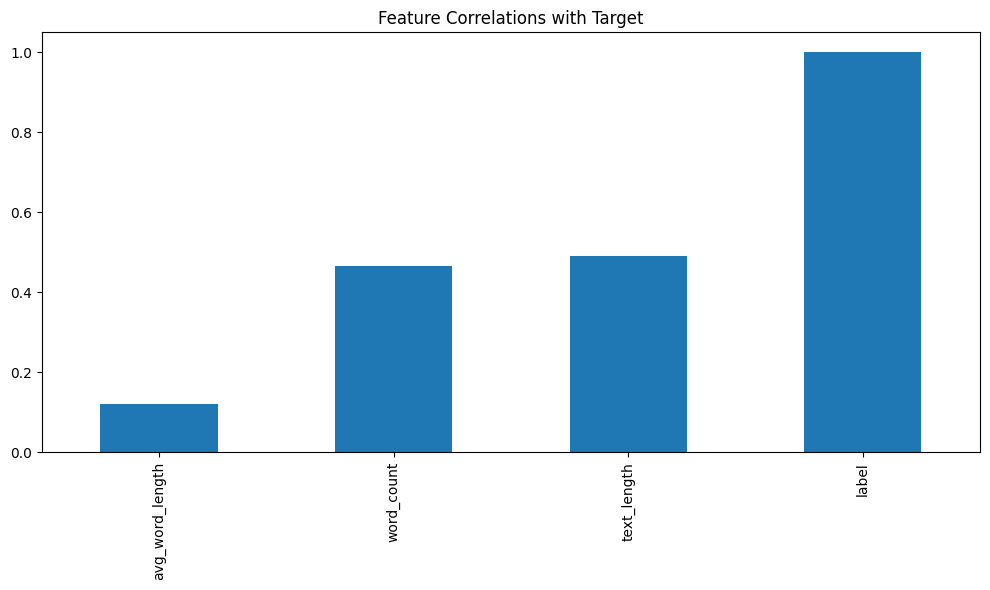


Splitting data...

Label distribution before splitting:
label
0    4452
1     653
Name: count, dtype: int64

Train set: 3573 samples
Validation set: 765 samples
Test set: 767 samples

Label distribution in splits:
Train: label
0    0.877134
1    0.122866
Name: proportion, dtype: float64
Validation: label
0    0.852288
1    0.147712
Name: proportion, dtype: float64
Test: label
0    0.868318
1    0.131682
Name: proportion, dtype: float64

Train set label distribution:
label
0    0.877134
1    0.122866
Name: proportion, dtype: float64

Validation set label distribution:
label
0    0.852288
1    0.147712
Name: proportion, dtype: float64

Test set label distribution:
label
0    0.868318
1    0.131682
Name: proportion, dtype: float64

Data splits saved successfully


In [132]:
data_prep = DataPreparation()
train_df, val_df, test_df = data_prep.run_preparation("SMSSpamCollection")

# ASSIGNMENT 2

In [134]:
# ========== DVC Implementation ==========
import os

# Save the raw data as raw_data.csv
print("Saving raw data...")
raw_data = pd.read_csv("SMSSpamCollection", sep='\t', names=['label', 'message'])
raw_data.to_csv("raw_data.csv", index=False)
print("Raw data saved to raw_data.csv")

Saving raw data...


Raw data saved to raw_data.csv


In [135]:
!pip install dvc

In [136]:
# Initialize DVC
print("\nInitializing DVC...")
if not os.path.exists(".dvc"):
    !dvc init --no-scm
    print("DVC initialized")
else:
    print("DVC already initialized")

# Add raw data to DVC
# Make sure we're in the right directory
print("Current working directory:", os.getcwd())
try:
    !dvc add raw_data.csv
except Exception as e:
    print(f"Error adding file to DVC: {e}")


Initializing DVC...
DVC already initialized
Current working directory: /mnt/c/Users/dhruv/Downloads/AppliedMachineLearning/Assignment_2
⠋ Checking graph                                       core>
Adding...                                                                       
!
                                                                                
!
  0% Checking cache in '/mnt/c/Users/dhruv/Downloads/AppliedMachineLearning/Assi
                                                                                
!
  0%|          |Checking out /mnt/c/Users/dhruv/Downlo0/1 [00:00<?,    ?files/s]
100% Adding...|████████████████████████████████████████|1/1 [00:00,  9.40file/s]


In [137]:
!dvc status

Data and pipelines are up to date.                                              


In [138]:
!pwd

/mnt/c/Users/dhruv/Downloads/AppliedMachineLearning/Assignment_2




==== Creating first version (random_state=42) ====

Initial data shape: (5572, 2)

Sample of loaded data:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Loaded 5572 messages

Label distribution:
label
0    0.865937
1    0.134063
Name: proportion, dtype: float64

Label mapping: 0=ham, 1=spam
Removed 403 duplicate messages

Performing EDA...

Label Distribution:
label
0    0.872086
1    0.127914
Name: proportion, dtype: float64

Message Length Statistics:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
0      4452.0   66.897350  43.656041   2.0   33.0   52.0   88.0  243.0
1       653.0  137.

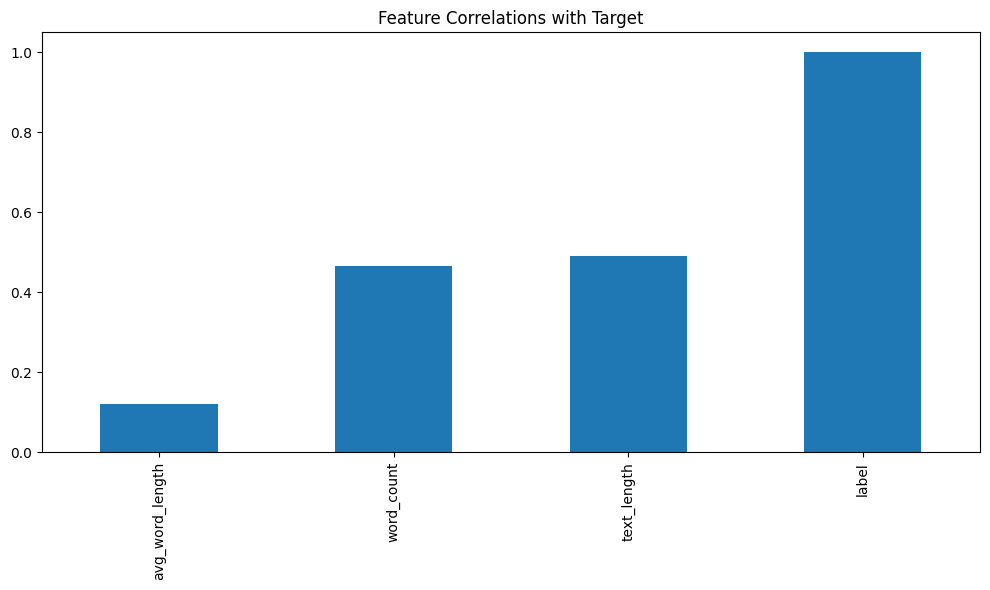


Splitting data...

Label distribution before splitting:
label
0    4452
1     653
Name: count, dtype: int64

Train set: 3573 samples
Validation set: 765 samples
Test set: 767 samples

Label distribution in splits:
Train: label
0    0.877134
1    0.122866
Name: proportion, dtype: float64
Validation: label
0    0.852288
1    0.147712
Name: proportion, dtype: float64
Test: label
0    0.868318
1    0.131682
Name: proportion, dtype: float64

Train set label distribution:
label
0    0.877134
1    0.122866
Name: proportion, dtype: float64

Validation set label distribution:
label
0    0.852288
1    0.147712
Name: proportion, dtype: float64

Test set label distribution:
label
0    0.868318
1    0.131682
Name: proportion, dtype: float64

Data splits saved successfully


In [139]:
# Create first version (random_state=42)
print("\n\n==== Creating first version (random_state=42) ====")
data_prep = DataPreparation()
# Load raw data
df = data_prep.load_data("SMSSpamCollection")

# Save raw data
df.to_csv("raw_data.csv", index=False)

# Process data
df = data_prep.remove_duplicates(df)
df = data_prep.handle_outliers(df)
df = data_prep.analyze_data(df)
df = data_prep.prepare_features(df)
df = data_prep.analyze_correlations(df)

# Split data with random_state=42
train_df, val_df, test_df = data_prep.split_data(df, random_state=42)

# Save splits
data_prep.save_splits(train_df, val_df, test_df)

In [140]:
# Add to DVC
!dvc add train.csv validation.csv test.csv

⠋ Checking graph                                       core>
  0% Adding...|                          | train.csv |0/3 [00:00<?,     ?file/s]
!
                                                                                
!
  0% Checking cache in '/mnt/c/Users/dhruv/Downloads/AppliedMachineLearning/Assi
                                                                                
!
  0%|          |Checking out /mnt/c/Users/dhruv/Downlo0/1 [00:00<?,    ?files/s]
  0% Adding...|                     | validation.csv |0/3 [00:00<?,     ?file/s]
!
                                                                                
!
  0% Checking cache in '/mnt/c/Users/dhruv/Downloads/AppliedMachineLearning/Assi
                                                                                
!
  0%|          |Checking out /mnt/c/Users/dhruv/Downlo0/1 [00:00<?,    ?files/s]
 67% Adding...|███████████████▎       | test.csv |2/3 [00:00<00:00, 14.47file/s]
!
                                  

In [141]:
# Commit the first version
!git add raw_data.csv.dvc train.csv.dvc validation.csv.dvc test.csv.dvc
!git commit -m "First data version with random_state=42"

print("\nFirst version created and committed")

[main e9d870c] First data version with random_state=42
 4 files changed, 24 insertions(+)
 create mode 100644 Assignment_2/raw_data.csv.dvc
 create mode 100644 Assignment_2/test.csv.dvc
 create mode 100644 Assignment_2/train.csv.dvc
 create mode 100644 Assignment_2/validation.csv.dvc

First version created and committed




==== Creating second version (random_state=123) ====

Initial data shape: (5572, 2)

Sample of loaded data:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Loaded 5572 messages

Label distribution:
label
0    0.865937
1    0.134063
Name: proportion, dtype: float64

Label mapping: 0=ham, 1=spam
Removed 403 duplicate messages

Performing EDA...

Label Distribution:
label
0    0.872086
1    0.127914
Name: proportion, dtype: float64

Message Length Statistics:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
0      4452.0   66.897350  43.656041   2.0   33.0   52.0   88.0  243.0
1       653.0  13

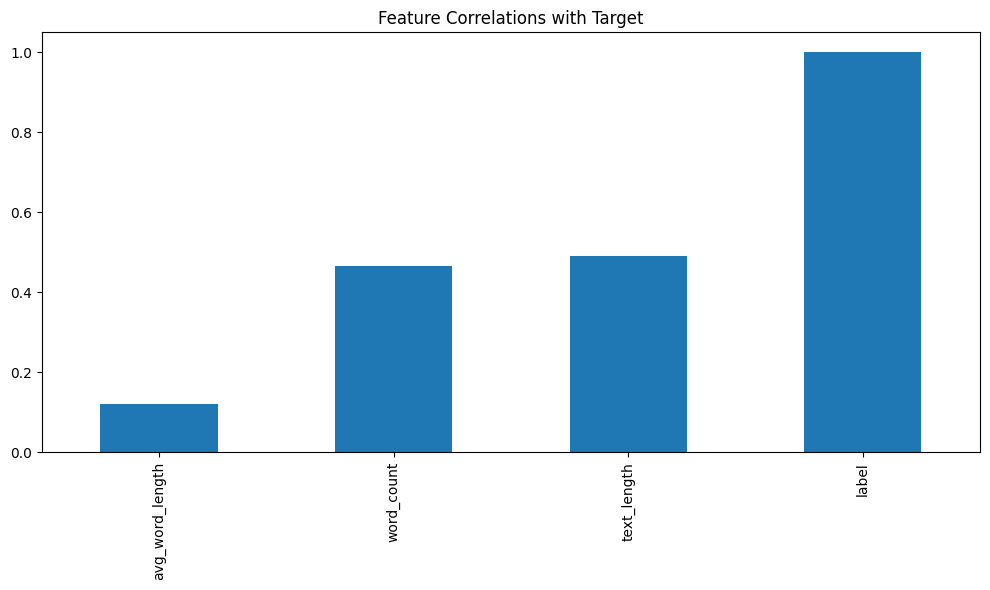


Splitting data...

Label distribution before splitting:
label
0    4452
1     653
Name: count, dtype: int64

Train set: 3573 samples
Validation set: 765 samples
Test set: 767 samples

Label distribution in splits:
Train: label
0    0.870137
1    0.129863
Name: proportion, dtype: float64
Validation: label
0    0.887582
1    0.112418
Name: proportion, dtype: float64
Test: label
0    0.865711
1    0.134289
Name: proportion, dtype: float64

Train set label distribution:
label
0    0.870137
1    0.129863
Name: proportion, dtype: float64

Validation set label distribution:
label
0    0.887582
1    0.112418
Name: proportion, dtype: float64

Test set label distribution:
label
0    0.865711
1    0.134289
Name: proportion, dtype: float64

Data splits saved successfully


In [142]:
# Create second version (random_state=123)
print("\n\n==== Creating second version (random_state=123) ====")
data_prep = DataPreparation()

# Load raw data directly from the original source
df = data_prep.load_data("SMSSpamCollection")

# Process data
df = data_prep.remove_duplicates(df)
df = data_prep.handle_outliers(df)
df = data_prep.analyze_data(df)
df = data_prep.prepare_features(df)
df = data_prep.analyze_correlations(df)

# Split data with random_state=123
train_df, val_df, test_df = data_prep.split_data(df, random_state=123)

# Save splits
data_prep.save_splits(train_df, val_df, test_df)

In [143]:
# Update DVC
!dvc add train.csv validation.csv test.csv

⠋ Checking graph                                       core>
  0% Adding...|                          | train.csv |0/3 [00:00<?,     ?file/s]
!
                                                                                
!
  0% Checking cache in '/mnt/c/Users/dhruv/Downloads/AppliedMachineLearning/Assi
                                                                                
!
  0%|          |Checking out /mnt/c/Users/dhruv/Downlo0/1 [00:00<?,    ?files/s]
  0% Adding...|                     | validation.csv |0/3 [00:00<?,     ?file/s]
!
                                                                                
!
  0% Checking cache in '/mnt/c/Users/dhruv/Downloads/AppliedMachineLearning/Assi
                                                                                
!
  0%|          |Checking out /mnt/c/Users/dhruv/Downlo0/1 [00:00<?,    ?files/s]
 67% Adding...|███████████████▎       | test.csv |2/3 [00:00<00:00, 13.13file/s]
!
                                  

In [144]:
!dvc status

raw_data.csv.dvc:                                                               
	changed outs:
		modified:           raw_data.csv


In [145]:
# Commit the second version
!git add train.csv.dvc validation.csv.dvc test.csv.dvc
!git commit -m "Second data version with random_state=123"

print("\nSecond version created and committed")

[main b69f9b7] Second data version with random_state=123
 3 files changed, 6 insertions(+), 6 deletions(-)

Second version created and committed


In [146]:
print("\n\n==== Checking out first version (random_state=42) ====")
# Get the first commit hash
!git log --oneline | grep "First data version" | cut -d " " -f 1



==== Checking out first version (random_state=42) ====
e9d870c


In [147]:
commit_hash = 'e9d870c'

# Checkout the data from the first version
!git checkout {commit_hash} -- train.csv.dvc validation.csv.dvc test.csv.dvc
!dvc checkout train.csv validation.csv test.csv

Building workspace index                              |3.00 [00:00,  206entry/s]
Comparing indexes                                    |4.00 [00:00, 4.20kentry/s]
Applying changes                                      |3.00 [00:00,  47.9file/s]
M       train.csv
M       validation.csv
M       test.csv


In [148]:
# Load and print distributions
print("\nDistribution of target variable in first version:")
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("validation.csv")
test_df = pd.read_csv("test.csv")

print("\nTrain.csv distribution:")
print(train_df['label'].value_counts())

print("\nValidation.csv distribution:")
print(val_df['label'].value_counts())

print("\nTest.csv distribution:")
print(test_df['label'].value_counts())


Distribution of target variable in first version:

Train.csv distribution:
label
0    3134
1     439
Name: count, dtype: int64

Validation.csv distribution:
label
0    652
1    113
Name: count, dtype: int64

Test.csv distribution:
label
0    666
1    101
Name: count, dtype: int64


In [149]:
# Checkout the second version and print distributions
print("\n\n==== Checking out second version (random_state=123) ====")
# Get the second commit hash
!git log --oneline | grep "Second data version" | cut -d " " -f 1



==== Checking out second version (random_state=123) ====
b69f9b7


In [150]:
commit_hash = 'b69f9b7'

# Checkout the data from the second version
!git checkout {commit_hash} -- train.csv.dvc validation.csv.dvc test.csv.dvc
!dvc checkout train.csv validation.csv test.csv

Building workspace index                              |3.00 [00:00,  202entry/s]
Comparing indexes                                    |4.00 [00:00, 5.14kentry/s]
Applying changes                                      |3.00 [00:00,  46.9file/s]
M       train.csv
M       validation.csv
M       test.csv


In [151]:
# Load and print distributions
print("\nDistribution of target variable in second version:")
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("validation.csv")
test_df = pd.read_csv("test.csv")

print("\nTrain.csv distribution:")
print(train_df['label'].value_counts())

print("\nValidation.csv distribution:")
print(val_df['label'].value_counts())

print("\nTest.csv distribution:")
print(test_df['label'].value_counts())


Distribution of target variable in second version:

Train.csv distribution:
label
0    3109
1     464
Name: count, dtype: int64

Validation.csv distribution:
label
0    679
1     86
Name: count, dtype: int64

Test.csv distribution:
label
0    664
1    103
Name: count, dtype: int64
